# Exploratory Data Analysis
Wow. Looks like I'm back to Python. Let's do this boiz.

## To Consider
- Plots of fertility rates (average number of children a woman bears in a lifetime)

## Some Questions
- What are the best predictors of using contraception?
    - How about long-term contraception?
    - What about short-term contraception?
- What is the relationship between standard-of-living and number of children?
- What is the relationship between fertility rate and contraceptive use?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
sns.set(style="white", context="talk")

In [2]:
contra = pd.read_csv('../../1-data/contraceptive_for_students.csv')

Our dataset, made available by the <a href='https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice'>UCI Machine Learning Repository</a>, is a subset of the 1987 National Indonesian contraceptive survey. Women who were married who were not pregnant were interviewed about whether they used birth control contraceptive methods. The original `contraceptive` covariate has three possible values. A `1` indicates that no contraceptive was used, a `2` indicates the use of a long-term contraceptive method, and a `3` indicates a preference for a short-term contraceptive. To make `contraceptive` variable ordinal, we will be switched such that `0` will indicate no contraceptive, `1` will indicate a short-term contraceptive preference, and `2` will indicate a long-term preference.

In [3]:
this_dic = {1:0, 3:1, 2:2}
contra['contraceptive'] = contra['contraceptive'].map(this_dic)

In [4]:
contra.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,0
1,45,1,3,10,1,1,3,4,0,0
2,43,2,3,7,1,1,3,4,0,0
3,42,3,2,9,1,1,3,3,0,0
4,36,3,3,8,1,1,3,2,0,0


## Data Dictionary
The following is the data dictionary provided by the UCI Machine Learning Repository.

1. Wife's age (numerical)
2. Wife's education (categorical) 1=low, 2, 3, 4=high
3. Husband's education (categorical) 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary) 0=Non-Islam, 1=Islam
6. Wife's now working? (binary) 0=Yes, 1=No
7. Husband's occupation (categorical) 1, 2, 3, 4
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
9. Media exposure (binary) 0=Good, 1=Not good
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

# Summary Statistics

## Counts
Most of the women do not have contraceptive.

In [ ]:
contra.groupby('contraceptive').contraceptive.count()

I am using a color scheme by <a href='https://www.instagram.com/colours.cafe/'>Colours Cafe</a>. Here is the distribution of the data.

In [ ]:
plt.figure(figsize=(8,7))
ax = sns.barplot(x=contra.groupby('contraceptive').contraceptive.count().index,
                 y=contra.groupby('contraceptive').contraceptive.count() / contra.shape[0],
                 palette=['#27706B', '#DF6589', '#FFC3AF'])
ax.set(ylabel='Frequencies',
       xlabel='Contraceptive Method',
       title='Distribution of Contraceptive Method Choices');

This plot is expected. Indonesia is a Muslim country.

In [ ]:
plt.figure(figsize=(8,7))
ax = sns.barplot(x=contra.groupby('wife_religion').contraceptive.count().index,
                 y=contra.groupby('wife_religion').contraceptive.count() / contra.shape[0],
                 palette=['#27706B', '#DF6589', '#FFC3AF'])
ax.set(ylabel='Frequencies',
       xlabel='Religion (0: Non-Islam, 1: Islam)',
       title='Distribution of Religion');

In [ ]:
plt.figure(figsize=(8,7))
ax = sns.barplot(x=contra['media_exposure'].unique(),
                 y=contra.groupby('media_exposure').contraceptive.count() / contra.shape[0],
                 palette=['#27706B', '#DF6589', '#FFC3AF'])
ax.set(ylabel='Frequencies',
       xlabel='Exposure Level (0: Good, 1: Not Good)',
       title='Distribution of Media Exposure');

## Measures of center and spread

In [ ]:
contra.mean()

In [ ]:
contra.std()

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='variable',
                 y='value',
                 data=pd.melt(contra[contra.columns.difference(['wife_age', 'num_child', 'media_exposure', 'wife_religion'])]),
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(ylabel='Value', xlabel='Column', title='Distribution of Nominal Columns');
plt.show();

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='variable',
                 y='value',
                 data=pd.melt(contra[['wife_age', 'num_child']]),
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(ylabel='Value',
       xlabel='Column',
       title='Distribution of Discrete Columns')
plt.show();

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='wife_age',
                 y='num_child',
                 data=contra,
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

ax.set(ylabel='Number of Children',
       xlabel='Wife Age',
       title='Distribution of Children By Wife Age')

plt.savefig('../../4-visuals/box-children-per-age.png', dpi=400);

Next, I want to see what type of contraceptive methods are used by those in their 10's, 20's, 30's, and 40's. We need to wrangle the data a bit to do this.

In [ ]:
labels = []
edges = np.arange(15, 51, 5)
for ix in range(len(edges)-1):
    labels.append(str(edges[ix]) + ' to ' + str(edges[ix+1]))
    
contra['age_bin'] = pd.cut(contra.wife_age, bins=edges, labels=labels)
age_contra = contra.groupby(['age_bin', 'contraceptive'], as_index=False).size().to_frame().reset_index()
age_contra = age_contra.rename({0:'count'}, axis=1)

num_in_bins = contra.groupby('age_bin', as_index=False).size()
age_contra['total'] = np.array(np.repeat(num_in_bins, len(contra['contraceptive'].unique())))

age_contra['freq'] = age_contra['count'] / age_contra['total']

In [ ]:
plt.figure(figsize=(15,10))
age_contra['contra_description'] = age_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x='age_bin',
            y='freq',
            hue='contra_description',
            data=age_contra,
            palette=['#27706B', '#DF6589', '#FFC3AF'])


ax.set(ylabel='Relative Frequency', xlabel='Age Group', title='Distribution of Contraception Per Age Group')
ax.legend(title='Contraceptive Method')
plt.savefig('../../4-visuals/bar-contra-per-age.png', dpi=400)
plt.show();

Next, I want to see how the number of children a woman has affects their choice of contraceptive method.

In [ ]:
labels = []
edges = np.arange(1, np.max(contra['num_child'])+1, 2)
edges[len(edges)-1] = edges[len(edges)-1]+1
for ix in range(len(edges)-1):
    labels.append(str(edges[ix]) + ' to ' + str(edges[ix+1]))
    
contra['num_child_bin'] = pd.cut(contra.num_child, bins=edges, labels=labels)

child_contra = contra.groupby(['num_child_bin', 'contraceptive'], as_index=False).size().to_frame().reset_index()
child_contra = child_contra.rename({0:'count'}, axis=1)

num_in_bins = contra.groupby('num_child_bin', as_index=False).size().to_frame().reset_index()
num_in_bins = num_in_bins.rename({0:'total'}, axis=1)

child_contra = child_contra.merge(num_in_bins, how='left', on='num_child_bin')
child_contra['this_freq'] = child_contra['count'] / child_contra['total']

In [ ]:
plt.figure(figsize=(15,10))
child_contra['contra_description'] = child_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x='num_child_bin',
            y='this_freq',
            hue='contra_description',
            data=child_contra,
            palette=['#27706B', '#DF6589', '#FFC3AF'])


ax.set(ylabel='Relative Frequency', xlabel='Number of Children', title='Distribution of Contraception Per Number of Children')
ax.legend(title='Contraceptive Method', loc='upper left')
plt.savefig('../../4-visuals/bar-contra-per-child.png', dpi=400)
plt.show();

What is the distribution of women who work? **CAUTION**: The encoding is super stupid for the `wife_work` column.

In [ ]:
# X WILL BE EDUCATION LEVEL
# Y WILL BE FREQUENCY OF WORKING
educ_work = contra.groupby(['wife_education', 'wife_work'], as_index=False).size().to_frame().reset_index()
educ_work = educ_work.rename({0:'count'}, axis=1)

num_in_bins = contra.groupby('wife_education', as_index=False).size()
educ_work['total'] = np.array(np.repeat(num_in_bins, len(contra['wife_work'].unique())))

educ_work['freq'] = educ_work['count'] / educ_work['total']

In [ ]:
plt.figure(figsize=(15,10))
educ_work['work_description'] = educ_work['wife_work'].map({1:'Unemployed', 0:'Employed'})
ax = sns.barplot(x='wife_education',
            y='freq',
            hue='work_description',
            data=educ_work,
            palette=['#27706B', '#DF6589', '#FFC3AF'])


ax.set(ylabel='Relative Frequency', xlabel='Education Level (1: Low, 4: High)', title='Distribution of Work Per Education Level')
ax.legend(title='Wife Work', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../4-visuals/bar-contra-per-age.png', dpi=400)
plt.show();

Next, I want to create a plot to see the relationship between a woman's work, her education level, and her choice of contraception method.

This requires something of <a href='https://stackoverflow.com/questions/47138271/how-to-create-a-stacked-bar-chart-for-my-dataframe-using-seaborn'>this sort</a>, but I want to keep the dodges as in the above plot.

In [ ]:
educ_work_contra = contra.groupby(['wife_education', 'wife_work', 'contraceptive'], as_index=False).size().to_frame().reset_index()
educ_work_contra = educ_work_contra.rename({0:'count'}, axis=1)

In [ ]:
plt.figure(figsize=(15,10))
educ_work_contra['work_description'] = educ_work_contra['wife_work'].map({1:'Unemployed', 0:'Employed'})
educ_work_contra['Contraceptive Method'] = educ_work_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.catplot(x='wife_education',
                 y='count',
                 hue='Contraceptive Method',
                 col='work_description',
                 data=educ_work_contra,
                 kind='bar',
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

(ax.set_axis_labels('Education Level (1: Low, 4: High)', 'Absolute Frequencies')
  .set_titles('{col_name}'))

plt.savefig('../../4-visuals/bar-contra-per-employ-edu-abs.png', dpi=400)

plt.show();

In [ ]:
work_counts = contra['wife_work'].value_counts()
educ_work_contra['freq_relative_employment'] = np.where(educ_work_contra['wife_work']==0, educ_work_contra['count']/work_counts.loc[0], educ_work_contra['count']/work_counts.loc[1])

plt.figure(figsize=(15,10))
educ_work_contra['work_description'] = educ_work_contra['wife_work'].map({1:'Unemployed', 0:'Employed'})
educ_work_contra['Contraceptive Method'] = educ_work_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.catplot(x='wife_education',
                 y='freq_relative_employment',
                 hue='Contraceptive Method',
                 col='work_description',
                 data=educ_work_contra,
                 kind='bar',
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

(ax.set_axis_labels('Education Level (1: Low, 4: High)', 'Relative Frequencies')
  .set_titles('{col_name}'))

plt.savefig('../../4-visuals/bar-contra-per-employ-edu-rel.png', dpi=400)

plt.show();

# Summary


We are analyzing a subset of the 1987 National Indonesian Contraceptive Survey. This subset of the survey contains lifestyle information on 1,473 subjects and on their choice of contraception method. The survey subset has no missing values.

In [5]:
contra.shape[0]

1473

In this dataset, only 25% of the women are employed. The rest are not. We also know that on average, women in this subset are approximately 32. The minimum age was 16 and the maximum age was 49.

In [6]:
contra['wife_age'].apply(['min','mean', 'median', 'max', 'std'])

min       16.000000
mean      32.538357
median    32.000000
max       49.000000
std        8.227245
Name: wife_age, dtype: float64

In the dataset, there are more unemployed women than employed.

In [7]:
contra.groupby('wife_work').contraceptive.count() / contra.shape[0]

wife_work
0    0.250509
1    0.749491
Name: contraceptive, dtype: float64

Most women (85.06%) were Muslim. We do not have further information on the religion of the remaining 14.93%, although it should be noted that Indonesia's secondmost frequented religion is Christianity.

In [8]:
contra['wife_religion'].value_counts() / contra.shape[0]

1    0.850645
0    0.149355
Name: wife_religion, dtype: float64

Here is the breakdown of the choices of contraception within the dataset. Most women do not use contraception (42%). Of the women who do use contraception, 60.54% of them preferred short-term methods and 39.46% preferred long-term methods.

In [9]:
abs_contraceptive = contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}).value_counts().to_frame()
abs_contraceptive

,contraceptive
None,629
Short-term,511
Long-term,333


In [10]:
rel_contraceptive = (contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}).value_counts() / contra.shape[0]).to_frame()
rel_contraceptive

,contraceptive
None,0.427020
Short-term,0.346911
Long-term,0.226069


In [11]:
(rel_contraceptive['contraceptive'][1:3,] / (rel_contraceptive.loc['Short-term'] + rel_contraceptive.loc['Long-term'])[0]).to_frame()

,contraceptive
Short-term,0.60545
Long-term,0.39455


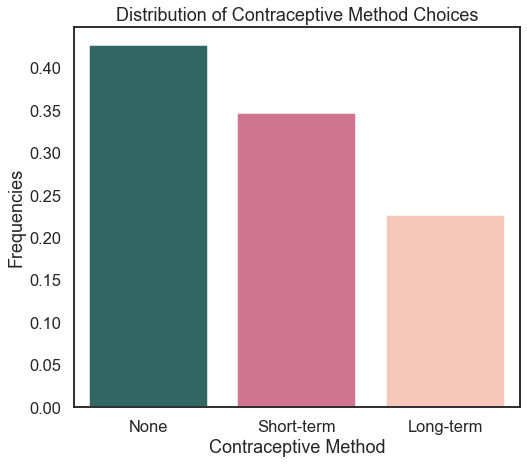

In [12]:
plt.figure(figsize=(8,7))
contra['Contraceptive Method'] = contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x=contra.groupby('Contraceptive Method').contraceptive.count().index,
                 y=contra.groupby('Contraceptive Method').contraceptive.count() / contra.shape[0],
                 order=['None', 'Short-term', 'Long-term'],
                 palette=['#27706B', '#DF6589', '#FFC3AF'])
ax.set(ylabel='Frequencies',
       xlabel='Contraceptive Method',
       title='Distribution of Contraceptive Method Choices');

We can combine the information on the age of the women with their choice of contraceptive method. We see that between the age groups, the frequency of choosing no contraception method dips from younger ages into the frequency for the 30-35 age range then increases again.

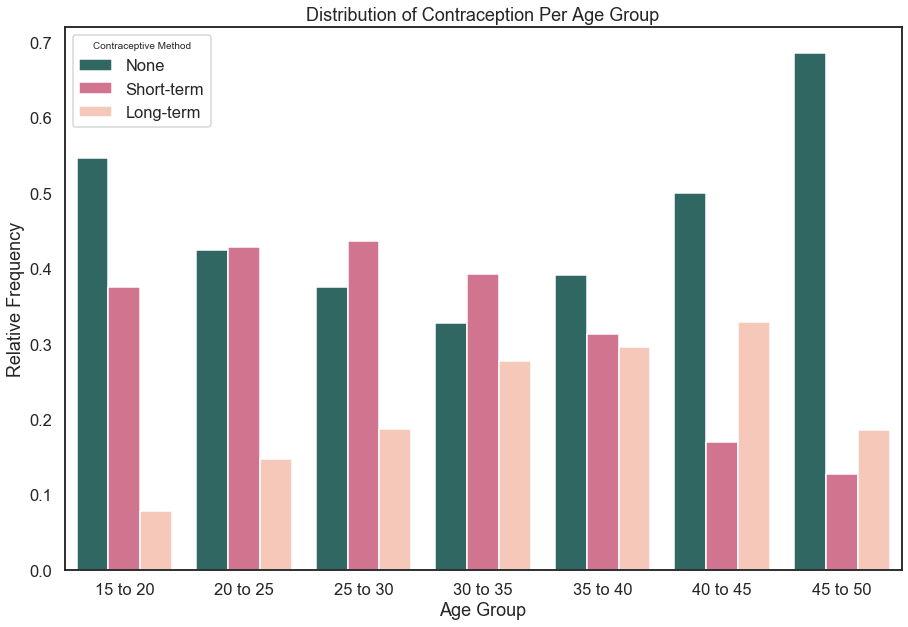

In [13]:
labels = []
edges = np.arange(15, 51, 5)
for ix in range(len(edges)-1):
    labels.append(str(edges[ix]) + ' to ' + str(edges[ix+1]))
    
contra['age_bin'] = pd.cut(contra.wife_age, bins=edges, labels=labels)
age_contra = contra.groupby(['age_bin', 'contraceptive'], as_index=False).size().to_frame().reset_index()
age_contra = age_contra.rename({0:'count'}, axis=1)

num_in_bins = contra.groupby('age_bin', as_index=False).size()
age_contra['total'] = np.array(np.repeat(num_in_bins, len(contra['contraceptive'].unique())))
age_contra['freq'] = age_contra['count'] / age_contra['total']

plt.figure(figsize=(15,10))
age_contra['contra_description'] = age_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x='age_bin',
            y='freq',
            hue='contra_description',
            data=age_contra,
            palette=['#27706B', '#DF6589', '#FFC3AF'])


ax.set(ylabel='Relative Frequency', xlabel='Age Group', title='Distribution of Contraception Per Age Group')
ax.legend(title='Contraceptive Method')
plt.savefig('../../4-visuals/bar-contra-per-age.png', dpi=400)
plt.show();

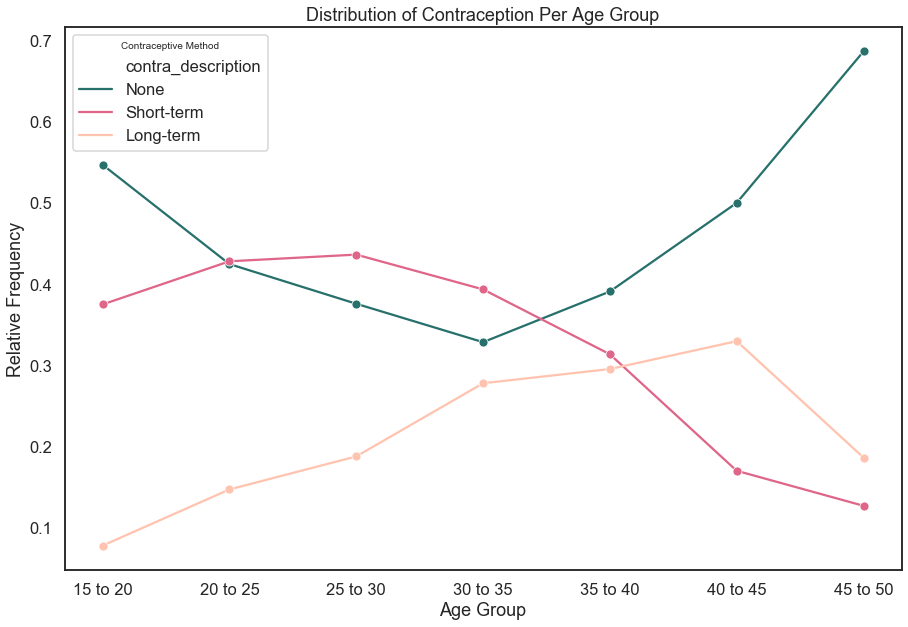

In [14]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='age_bin',
             y='freq',
             hue='contra_description',
             data=age_contra,
             palette=['#27706B', '#DF6589', '#FFC3AF'],
             marker='o')

ax.set(ylabel='Relative Frequency', xlabel='Age Group', title='Distribution of Contraception Per Age Group')
ax.legend(title='Contraceptive Method')


plt.savefig('../../4-visuals/line-contra-per-age.png', dpi=400)
plt.show()

We can explore the age groups some more to better understand why the trends of contraceptive methods are as shown.

- Are any of these age groups particularly more educated than the other?
- Are any of these age groups more employed than the other?
- Are any of these age groups more religious than the other?

We also are interested in how number of children may inform what kind of contraception method is used. First, we can visualize the number of children women have according to age. It is unsurprising that as age increases, there is more variance in how many children a women can have and that the mean number of children gradually increases.

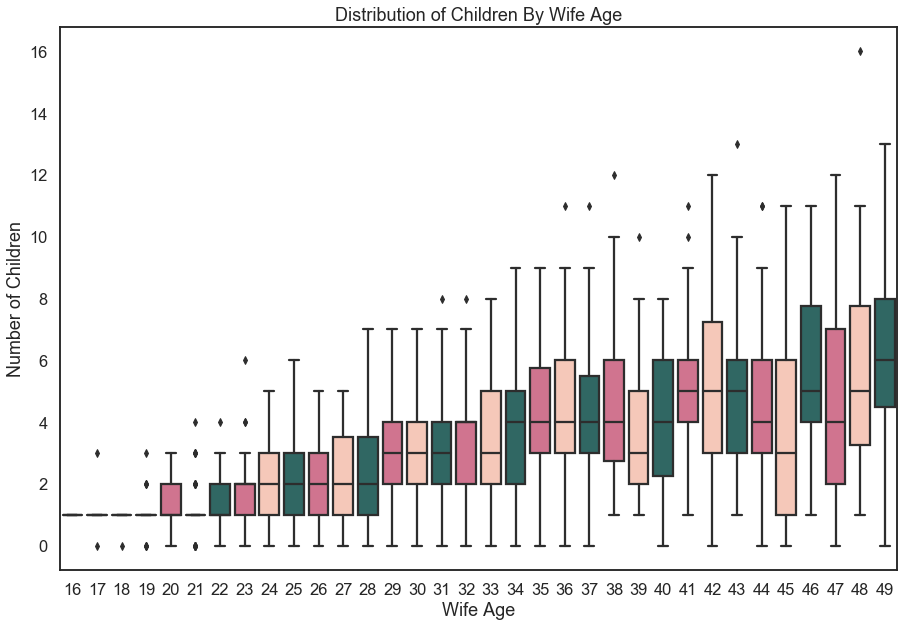

In [15]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='wife_age',
                 y='num_child',
                 data=contra,
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

ax.set(ylabel='Number of Children',
       xlabel='Wife Age',
       title='Distribution of Children By Wife Age')

plt.savefig('../../4-visuals/box-children-per-age.png', dpi=400);

Instead of looking at age as continuous, we can create nominal age bins to extract patterns on contraception method choices. The patterns found here are also unsurprising. For women with a greater number of children, the preference for no contraception is most common.

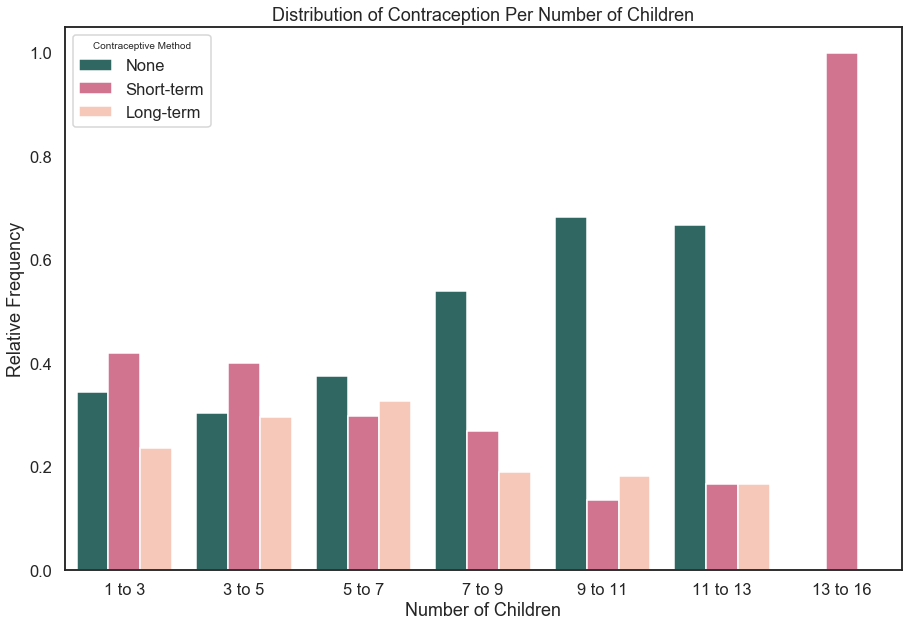

In [16]:
labels = []
edges = np.arange(1, np.max(contra['num_child'])+1, 2)
edges[len(edges)-1] = edges[len(edges)-1]+1
for ix in range(len(edges)-1):
    labels.append(str(edges[ix]) + ' to ' + str(edges[ix+1]))
    
contra['num_child_bin'] = pd.cut(contra.num_child, bins=edges, labels=labels)

child_contra = contra.groupby(['num_child_bin', 'contraceptive'], as_index=False).size().to_frame().reset_index()
child_contra = child_contra.rename({0:'count'}, axis=1)

num_in_bins = contra.groupby('num_child_bin', as_index=False).size().to_frame().reset_index()
num_in_bins = num_in_bins.rename({0:'total'}, axis=1)

child_contra = child_contra.merge(num_in_bins, how='left', on='num_child_bin')
child_contra['this_freq'] = child_contra['count'] / child_contra['total']

plt.figure(figsize=(15,10))
child_contra['contra_description'] = child_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x='num_child_bin',
            y='this_freq',
            hue='contra_description',
            data=child_contra,
            palette=['#27706B', '#DF6589', '#FFC3AF'])


ax.set(ylabel='Relative Frequency', xlabel='Number of Children', title='Distribution of Contraception Per Number of Children')
ax.legend(title='Contraceptive Method', loc='upper left')
plt.savefig('../../4-visuals/bar-contra-per-child.png', dpi=400)
plt.show();

The below plot can be difficult to interpret. The lines do not show an "over time" relationship. The lines are "over quantity children per woman".

/opt/anaconda3/lib/python3.7/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


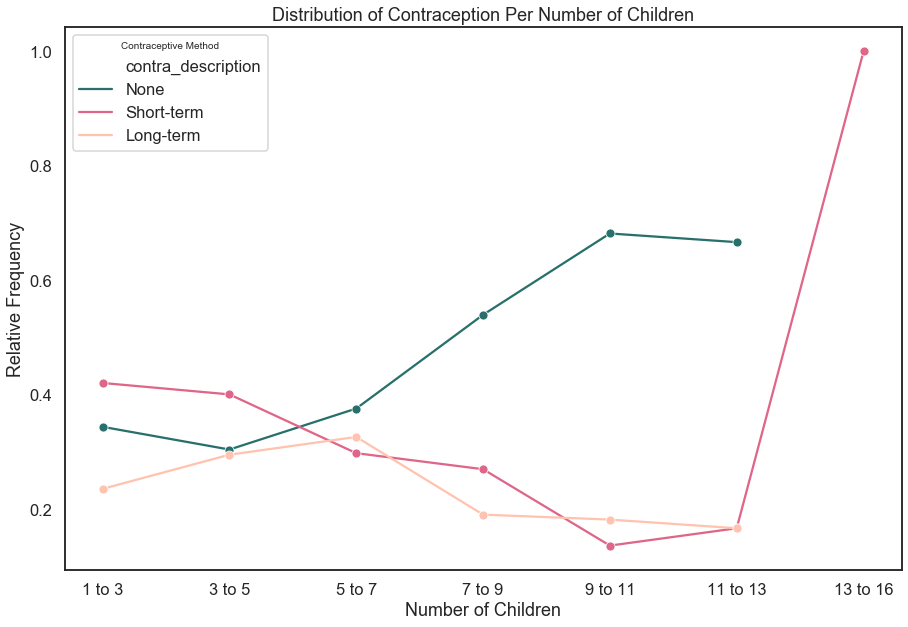

In [17]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='num_child_bin',
            y='this_freq',
            hue='contra_description',
            data=child_contra,
            palette=['#27706B', '#DF6589', '#FFC3AF'],
            marker='o')


ax.set(ylabel='Relative Frequency', xlabel='Number of Children', title='Distribution of Contraception Per Number of Children')
ax.legend(title='Contraceptive Method', loc='upper left')
plt.savefig('../../4-visuals/line-contra-per-child.png', dpi=400)
plt.show();

To add some color to this line of thought, we might answer the following questions.

- On average, how many children do working women have and how many children do non-working women have?

The dataset is imbalanced in that there are more unemployed women than employed ones. Among all levels of education, this imbalance remains, but we do see that in the most educated group of women (education level 4), there are relatively more working women than in the other education level groups.

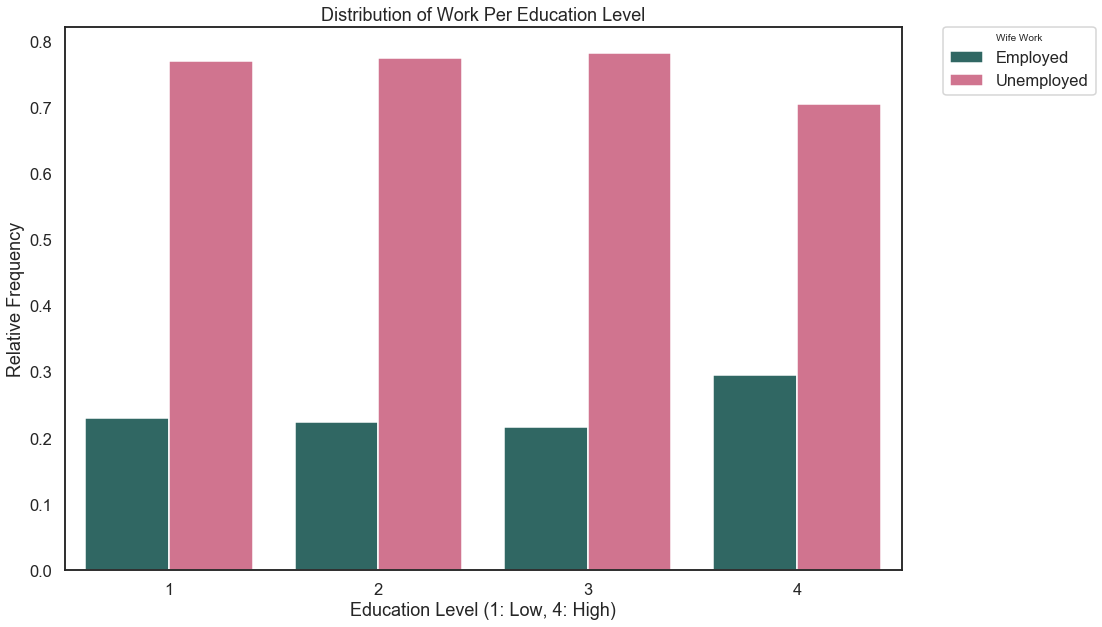

In [18]:
# X WILL BE EDUCATION LEVEL
# Y WILL BE FREQUENCY OF WORKING
educ_work = contra.groupby(['wife_education', 'wife_work'], as_index=False).size().to_frame().reset_index()
educ_work = educ_work.rename({0:'count'}, axis=1)

num_in_bins = contra.groupby('wife_education', as_index=False).size()
educ_work['total'] = np.array(np.repeat(num_in_bins, len(contra['wife_work'].unique())))

educ_work['freq'] = educ_work['count'] / educ_work['total']

plt.figure(figsize=(15,10))
educ_work['work_description'] = educ_work['wife_work'].map({1:'Unemployed', 0:'Employed'})
ax = sns.barplot(x='wife_education',
            y='freq',
            hue='work_description',
            data=educ_work,
            palette=['#27706B', '#DF6589', '#FFC3AF'])


ax.set(ylabel='Relative Frequency', xlabel='Education Level (1: Low, 4: High)', title='Distribution of Work Per Education Level')
ax.legend(title='Wife Work', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../4-visuals/bar-contra-per-age.png', dpi=400)
plt.show();

The table below shows the counts of women's contraceptive method choices per employment status. We may be interested in doing a $\chi^2$ test for independence on the following table.

In [19]:
contra['Contraceptive Method'] = contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
contra['Employment'] = contra['wife_work'].map({1:'Unemployed', 0:'Employed'})
pd.crosstab(contra['Employment'], contra['Contraceptive Method'], normalize='index')

Contraceptive Method,Long-term,None,Short-term
Employment,,,
Employed,0.241192,0.460705,0.298103
Unemployed,0.221014,0.415761,0.363225


To better visualize the relationship between education level, employment status, and choice of contraception, we can look at the relative frequencies of method choices in the following plot grid.

<Figure size 1080x720 with 0 Axes>

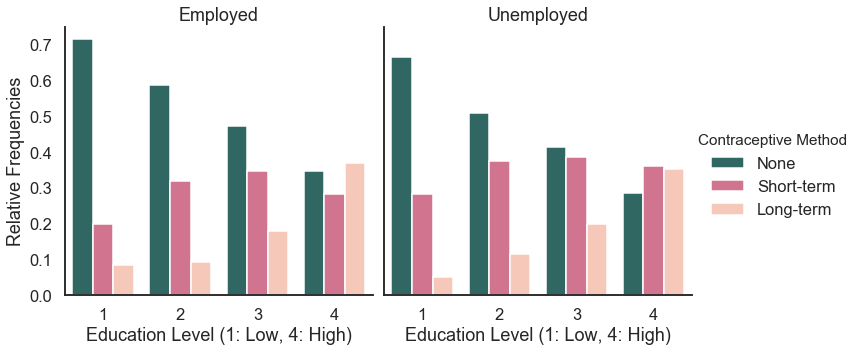

In [20]:
educ_work_contra = contra.groupby(['wife_education', 'wife_work', 'contraceptive'], as_index=False).size().to_frame().reset_index()
educ_work_contra = educ_work_contra.rename({0:'count'}, axis=1)

educ_work_counts = contra.groupby(['wife_work', 'wife_education']).size().to_frame().reset_index()
educ_work_counts = educ_work_counts.rename({0:'total'}, axis=1)

educ_work_contra = educ_work_contra.merge(educ_work_counts, how='left')
educ_work_contra['freq'] = educ_work_contra['count'] / educ_work_contra['total']

plt.figure(figsize=(15,10))
educ_work_contra['work_description'] = educ_work_contra['wife_work'].map({1:'Unemployed', 0:'Employed'})
educ_work_contra['Contraceptive Method'] = educ_work_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.catplot(x='wife_education',
                 y='freq',
                 hue='Contraceptive Method',
                 col='work_description',
                 data=educ_work_contra,
                 kind='bar',
                 palette=['#27706B', '#DF6589', '#FFC3AF'])

(ax.set_axis_labels('Education Level (1: Low, 4: High)', 'Relative Frequencies')
  .set_titles('{col_name}'))

plt.savefig('../../4-visuals/bar-contra-per-employ-edu-rel.png', dpi=400)

plt.show();

Some additional things we can explore are as follows.

- Are women that are employed more likely to have a higher standard of living?
- What contributes most to a higher standard of living? The woman's contribution or the man's contribution?
- Is it possible to predict how many children simply based off the characteristic of the man (his education, his occupation, and standard of living)?